<a id='startpage'></a>

# Прогноз оттока клиентов «Ниединогоразрыва.ком»

## План

- Описание проекта
- Предварительное изучение данных
- Исследовательский анализ данных
- Подбор моделей и параметров, метрик
- Сравнение результатов, выбор лучшей модели
- Выводы

## Описание проекта

Перед нами стоит задача научиться прогнозировать отток клиентов у оператора связи «Ниединогоразрыва.ком». 
Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. 
Командой оператора предоставлены персональные данные о некоторых клиентах, информация об их тарифах и договорах.

### Описание услуг

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

#### Информация о данных
      
- СustomerID — уникальный идентификатор пользователя
- Type - тип договора: ежемесячный, годовой и т.п.      
- PaperlessBilling - факт выставления счета на электронную почту        
- PaymentMethod - способ оплаты       
- MonthlyCharges - ежемесячные траты на услуги       
- TotalCharges - сумма всех потраченных денег на услуги       
- BeginDateNew - дата начала пользования услугами
- EndDateNew - дата окончания пользования услугами       
- Gender - гендер, пол        
- SeniorCitizen - наличие пенсионного статуса по возрасту        
- Partner - наличие супруга(и) или гражданский брак      
- Dependents - наличие иждивенцев       
- InternetService - наличие возможности пользования интернет-сервисом        
- OnlineSecurity - наличие оnline-security       
- OnlineBackup - наличие возможности создавать резервные копии online       
- DeviceProtection - наличие антивируса        
- TechSupport - наличие выделенной линии технической поддержки       
- StreamingTV - наличие стримингового телевидения        
- StreamingMovies - наличие возможности просмотра фильмов     
- MultipleLines - наличие возможности ведения параллельных линий во время звонка   

## Изучение данных из файлов

In [1]:
import pandas as pd
import numpy as np
from IPython.display import display

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from sklearn import svm
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
pd.options.mode.chained_assignment = None
from sklearn.model_selection import GridSearchCV
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

from sklearn.metrics import classification_report, confusion_matrix 

r_s = 250722 # random_state

import matplotlib.pyplot as plt
import seaborn as sns

import warnings 
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.set_option('display.float_format', '{:,.2f}'.format)

!pip install phik
import phik
from phik.report import plot_correlation_matrix
from phik import report

from scipy import stats as st
from scipy.stats import norm

# !pip install optuna
# from optuna.visualization import plot_optimization_history
# from optuna.visualization import plot_param_importances

In [2]:
df_personal = pd.read_csv('/datasets/final_provider/personal.csv')
df_contract = pd.read_csv('/datasets/final_provider/contract.csv')
df_internet = pd.read_csv('/datasets/final_provider/internet.csv')
df_phone = pd.read_csv('/datasets/final_provider/phone.csv')

In [3]:
def overview(data):
    display(data.sample(3))
    print("----------------------------", "\n")
    print(data.info(), "\n")
    print("----------------------------", "\n")
    print("Уникальные значения:")
    for column in data.columns:
        display(column, data[column].unique())
    print("----------------------------", "\n")
    print("Сумма пропусков:", data.isna().sum(), "\n")
    print("Дубликаты:", data.duplicated().sum(), "\n")
    print("----------------------------", "\n")
    display(data.describe().T)

### Персональные данные клиента (`df_personal`)

In [4]:
overview(df_personal)

customerID  gender  SeniorCitizen Partner Dependents
4003  0582-AVCLN  Female              0      No         No
4963  8313-AFGBW    Male              0     Yes         No
3261  2378-YIZKA  Female              0     Yes        Yes

---------------------------- 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB
None 

---------------------------- 

Уникальные значения:


'customerID'

array(['7590-VHVEG', '5575-GNVDE', '3668-QPYBK', ..., '4801-JZAZL',
       '8361-LTMKD', '3186-AJIEK'], dtype=object)

'gender'

array(['Female', 'Male'], dtype=object)

'SeniorCitizen'

array([0, 1])

'Partner'

array(['Yes', 'No'], dtype=object)

'Dependents'

array(['No', 'Yes'], dtype=object)

---------------------------- 

Сумма пропусков: customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64 

Дубликаты: 0 

---------------------------- 



count  mean  std  min  25%  50%  75%  max
SeniorCitizen 7,043.00  0.16 0.37 0.00 0.00 0.00 0.00 1.00

- Пропуски и дубликаты отсутствуют.
- В персональных данных размещена информация о гендере, наличии или отсутствии партнера, пенсионном статусе, материальной зависимости

### Информация о договоре (`df_contract`)

In [5]:
overview(df_contract)

customerID   BeginDate              EndDate      Type PaperlessBilling  \
6910  0530-IJVDB  2014-04-01                   No  Two year              Yes   
4429  3486-HOOGQ  2014-04-01                   No  Two year               No   
6537  1444-VVSGW  2014-03-01  2020-01-01 00:00:00  One year               No   

                  PaymentMethod  MonthlyCharges TotalCharges  
6910           Electronic check          114.60       7882.5  
4429  Bank transfer (automatic)           79.70       5743.3  
6537    Credit card (automatic)          115.65      7968.85

---------------------------- 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
None 

---------------------------- 

Уникальные значения:


'customerID'

array(['7590-VHVEG', '5575-GNVDE', '3668-QPYBK', ..., '4801-JZAZL',
       '8361-LTMKD', '3186-AJIEK'], dtype=object)

'BeginDate'

array(['2020-01-01', '2017-04-01', '2019-10-01', '2016-05-01',
       '2019-09-01', '2019-03-01', '2018-04-01', '2019-04-01',
       '2017-07-01', '2014-12-01', '2019-01-01', '2018-10-01',
       '2015-04-01', '2015-09-01', '2018-01-01', '2014-05-01',
       '2015-10-01', '2014-03-01', '2018-05-01', '2019-11-01',
       '2019-02-01', '2016-01-01', '2017-08-01', '2015-12-01',
       '2014-02-01', '2018-06-01', '2019-12-01', '2017-11-01',
       '2019-06-01', '2016-04-01', '2017-02-01', '2018-12-01',
       '2014-04-01', '2018-09-01', '2014-11-01', '2016-07-01',
       '2015-02-01', '2018-07-01', '2014-08-01', '2016-03-01',
       '2018-08-01', '2014-10-01', '2015-06-01', '2016-08-01',
       '2019-05-01', '2017-03-01', '2016-02-01', '2017-09-01',
       '2014-09-01', '2017-12-01', '2016-12-01', '2017-06-01',
       '2015-05-01', '2016-10-01', '2016-09-01', '2019-08-01',
       '2019-07-01', '2017-05-01', '2017-10-01', '2014-07-01',
       '2018-03-01', '2015-01-01', '2018-11-01', '2015-

'EndDate'

array(['No', '2019-12-01 00:00:00', '2019-11-01 00:00:00',
       '2019-10-01 00:00:00', '2020-01-01 00:00:00'], dtype=object)

'Type'

array(['Month-to-month', 'One year', 'Two year'], dtype=object)

'PaperlessBilling'

array(['Yes', 'No'], dtype=object)

'PaymentMethod'

array(['Electronic check', 'Mailed check', 'Bank transfer (automatic)',
       'Credit card (automatic)'], dtype=object)

'MonthlyCharges'

array([29.85, 56.95, 53.85, ..., 63.1 , 44.2 , 78.7 ])

'TotalCharges'

array(['29.85', '1889.5', '108.15', ..., '346.45', '306.6', '6844.5'],
      dtype=object)

---------------------------- 

Сумма пропусков: customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64 

Дубликаты: 0 

---------------------------- 



count  mean   std   min   25%   50%   75%    max
MonthlyCharges 7,043.00 64.76 30.09 18.25 35.50 70.35 89.85 118.75

- Пропуски и дубликаты отсутствуют.
- Столбцы `BeginDate` и `EndDate` необходимо перевести в формат даты.
- Значение 'No' в `EndDate` обозначает активного пользователя, который продолжает пользоваться услугами оператора. Необходимо создать категориальный столбец `Churn` для целевого признака, руководствуясь данными из `EndDate`.
- Тип столбца `TotalCharges`- object, необходимо перевести в числовой формат.

In [6]:
type(df_contract['BeginDate'][0])

str

Данные в формате `str`. Приведем данные столбца 'BeginDate' к типу данных `datetime`.

In [7]:
df_contract['BeginDateNew'] = pd.to_datetime(df_contract['BeginDate'], format='%Y/%m/%d')

Переведем данные столбца `TotalCharges` в числовой формат.

In [8]:
df_contract['TotalCharges'] = pd.to_numeric(df_contract['TotalCharges'], errors='coerce')
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   object        
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   BeginDateNew      7043 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(2), object(6)
memory usage: 495.3+ KB


Создадим столбец `Churn` для целевого признака, заполним строки следующим образом: 1 - клиент ушел, 0 - клиент продолжает пользоваться услугами.

In [9]:
df_contract['Churn'] = (df_contract['EndDate'] != 'No') * 1
df_contract.sample(5)

customerID   BeginDate              EndDate            Type  \
2058  0744-BIKKF  2014-02-01                   No        Two year   
3041  1406-PUQVY  2020-01-01                   No  Month-to-month   
6747  5245-VDBUR  2015-10-01                   No        One year   
409   7989-CHGTL  2019-09-01  2019-10-01 00:00:00  Month-to-month   
5793  3873-NFTGI  2018-12-01                   No  Month-to-month   

     PaperlessBilling              PaymentMethod  MonthlyCharges  \
2058               No  Bank transfer (automatic)           86.65   
3041              Yes           Electronic check           49.90   
6747               No               Mailed check           35.45   
409               Yes               Mailed check           19.60   
5793              Yes    Credit card (automatic)           55.50   

      TotalCharges BeginDateNew  Churn  
2058      6,224.80   2014-02-01      0  
3041         49.90   2020-01-01      0  
6747      1,958.95   2015-10-01      0  
409          19.60   2019-09-01      1  
5793        767.55   2018-12-01      0

In [10]:
df_contract['Churn'].value_counts(normalize=True)

0   0.73
1   0.27
Name: Churn, dtype: float64

Видно, что данные по целевому признаку несбалансированы: 26.5% приходится на отток, учтем это.

Посмотрим, есть ли у нас пользователи, которые оформили договор 1 февраля 2020.

In [11]:
new_clients = df_contract[df_contract['BeginDateNew'] == '2020-02-01']
display(new_clients)
len(new_clients)

customerID   BeginDate EndDate      Type PaperlessBilling  \
488   4472-LVYGI  2020-02-01      No  Two year              Yes   
753   3115-CZMZD  2020-02-01      No  Two year               No   
936   5709-LVOEQ  2020-02-01      No  Two year               No   
1082  4367-NUYAO  2020-02-01      No  Two year               No   
1340  1371-DWPAZ  2020-02-01      No  Two year               No   
3331  7644-OMVMY  2020-02-01      No  Two year               No   
3826  3213-VVOLG  2020-02-01      No  Two year               No   
4380  2520-SGTTA  2020-02-01      No  Two year               No   
5218  2923-ARZLG  2020-02-01      No  One year              Yes   
6670  4075-WKNIU  2020-02-01      No  Two year               No   
6754  2775-SEFEE  2020-02-01      No  Two year              Yes   

                  PaymentMethod  MonthlyCharges  TotalCharges BeginDateNew  \
488   Bank transfer (automatic)           52.55           NaN   2020-02-01   
753                Mailed check           20.25           NaN   2020-02-01   
936                Mailed check           80.85           NaN   2020-02-01   
1082               Mailed check           25.75           NaN   2020-02-01   
1340    Credit card (automatic)           56.05           NaN   2020-02-01   
3331               Mailed check           19.85           NaN   2020-02-01   
3826               Mailed check           25.35           NaN   2020-02-01   
4380               Mailed check           20.00           NaN   2020-02-01   
5218               Mailed check           19.70           NaN   2020-02-01   
6670               Mailed check           73.35           NaN   2020-02-01   
6754  Bank transfer (automatic)           61.90           NaN   2020-02-01   

      Churn  
488       0  
753       0  
936       0  
1082      0  
1340      0  
3331      0  
3826      0  
4380      0  
5218      0  
6670      0  
6754      0

11

Мы обнаружили 11 новых клиентов (`BeginDateNew`='2020-02-01' и `EndDate`='No'), по которым в целом нельзя спрогнозировать отток клиентов, поскольку они являются клиентами один день.

Посмотрим за какой временной период наши данные.

In [12]:
df_contract['BeginDateNew'].max() - df_contract['BeginDateNew'].min()

Timedelta('2314 days 00:00:00')

Данные представлены за 2283 дней, то есть за период более чем в 6 лет.

Удалим записи новых клиентов из данных.

In [13]:
df_contract = df_contract[df_contract['BeginDateNew'] != '2020-02-01']
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7032 non-null   object        
 1   BeginDate         7032 non-null   object        
 2   EndDate           7032 non-null   object        
 3   Type              7032 non-null   object        
 4   PaperlessBilling  7032 non-null   object        
 5   PaymentMethod     7032 non-null   object        
 6   MonthlyCharges    7032 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   BeginDateNew      7032 non-null   datetime64[ns]
 9   Churn             7032 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int64(1), object(6)
memory usage: 604.3+ KB


### Информация об интернет-услугах (`df_internet`)

In [14]:
overview(df_internet)

customerID InternetService OnlineSecurity OnlineBackup DeviceProtection  \
4352  5364-EVNIB     Fiber optic             No          Yes              Yes   
4680  3462-BJQQA     Fiber optic             No          Yes               No   
3237  2208-UGTGR     Fiber optic             No          Yes               No   

     TechSupport StreamingTV StreamingMovies  
4352          No          No              No  
4680          No         Yes              No  
3237          No         Yes             Yes

---------------------------- 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB
None 

---------------------------- 

Уникальные значения:


'customerID'

array(['7590-VHVEG', '5575-GNVDE', '3668-QPYBK', ..., '4801-JZAZL',
       '8361-LTMKD', '3186-AJIEK'], dtype=object)

'InternetService'

array(['DSL', 'Fiber optic'], dtype=object)

'OnlineSecurity'

array(['No', 'Yes'], dtype=object)

'OnlineBackup'

array(['Yes', 'No'], dtype=object)

'DeviceProtection'

array(['No', 'Yes'], dtype=object)

'TechSupport'

array(['No', 'Yes'], dtype=object)

'StreamingTV'

array(['No', 'Yes'], dtype=object)

'StreamingMovies'

array(['No', 'Yes'], dtype=object)

---------------------------- 

Сумма пропусков: customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64 

Дубликаты: 0 

---------------------------- 



count unique          top  freq
customerID        5517   5517   7005-CYUIL     1
InternetService   5517      2  Fiber optic  3096
OnlineSecurity    5517      2           No  3498
OnlineBackup      5517      2           No  3088
DeviceProtection  5517      2           No  3095
TechSupport       5517      2           No  3473
StreamingTV       5517      2           No  2810
StreamingMovies   5517      2           No  2785

- Пропуски и дубликаты отсутствуют.
- Данных меньше, чем в таблице о персональных данных клиента (5517/7043). Вероятнее всего, что часть клиентов не использует интернет-услуги.

### Информация об услугах телефонии (`df_phone`)

In [15]:
overview(df_phone)

customerID MultipleLines
5022  8029-XYPWT           Yes
2097  7488-MXJIV           Yes
1397  2882-WDTBA            No

---------------------------- 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB
None 

---------------------------- 

Уникальные значения:


'customerID'

array(['5575-GNVDE', '3668-QPYBK', '9237-HQITU', ..., '2234-XADUH',
       '8361-LTMKD', '3186-AJIEK'], dtype=object)

'MultipleLines'

array(['No', 'Yes'], dtype=object)

---------------------------- 

Сумма пропусков: customerID       0
MultipleLines    0
dtype: int64 

Дубликаты: 0 

---------------------------- 



count unique         top  freq
customerID     6361   6361  8851-RAGOV     1
MultipleLines  6361      2          No  3390

- Пропуски и дубликаты отсутствуют.
- Количество пользователей меньше чем в базе с персональными данными клиентов (6361/7043). Вероятно, что часть клиентов не использует телефонию.

Создадим общую таблицу для дальнейших исследований.

In [16]:
df = df_contract.merge(df_personal, on='customerID', 
                       how='left').merge(df_internet, on='customerID', 
                                         how='left').merge(df_phone, on='customerID', how='left')
df.shape

(7032, 22)

Для единого стиля таблицы переименуем столбцы `customerID` в `CustomerID`, `gender` в `Gender`.

In [17]:
df.rename(columns = {'customerID': 'СustomerID', 'gender': 'Gender'}, inplace = True)
df.columns.values

array(['СustomerID', 'BeginDate', 'EndDate', 'Type', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'BeginDateNew',
       'Churn', 'Gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'MultipleLines'], dtype=object)

Заменим пропуски в столбцах интернет-услуг и телефонии на 'No', предполагая, что клиенты не подключали данные виды услуг.

In [18]:
a = ['InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
     'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']
for column in a:
    df[column] = df[column].fillna('No')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7031
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   СustomerID        7032 non-null   object        
 1   BeginDate         7032 non-null   object        
 2   EndDate           7032 non-null   object        
 3   Type              7032 non-null   object        
 4   PaperlessBilling  7032 non-null   object        
 5   PaymentMethod     7032 non-null   object        
 6   MonthlyCharges    7032 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   BeginDateNew      7032 non-null   datetime64[ns]
 9   Churn             7032 non-null   int64         
 10  Gender            7032 non-null   object        
 11  SeniorCitizen     7032 non-null   int64         
 12  Partner           7032 non-null   object        
 13  Dependents        7032 non-null   object        
 14  InternetService   7032 n

Создадим столбец `DayUsed`, где отобразим время (в днях), в течении которого клиент пользуется (`Churn`=0) или пользовался (`Churn`=1) услугами оператора связи.
Для этого в столбце `EndDate` заполним строки с 'No' датой 01 февраля 2020 г и найдем разницу между датой окончания действия договора и его началом.

In [19]:
df['EndDateNew'] = df['EndDate'].replace('No', '2020-02-01')
df['EndDateNew'] = pd.to_datetime(df['EndDateNew'], format='%Y/%m/%d')
df['DayUsed'] = df['EndDateNew'] - df['BeginDateNew']
df['DayUsed'] = df['DayUsed'].dt.days

In [20]:
df = df.drop(columns = ['EndDate', 'BeginDate'], axis=1)

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7031
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   СustomerID        7032 non-null   object        
 1   Type              7032 non-null   object        
 2   PaperlessBilling  7032 non-null   object        
 3   PaymentMethod     7032 non-null   object        
 4   MonthlyCharges    7032 non-null   float64       
 5   TotalCharges      7032 non-null   float64       
 6   BeginDateNew      7032 non-null   datetime64[ns]
 7   Churn             7032 non-null   int64         
 8   Gender            7032 non-null   object        
 9   SeniorCitizen     7032 non-null   int64         
 10  Partner           7032 non-null   object        
 11  Dependents        7032 non-null   object        
 12  InternetService   7032 non-null   object        
 13  OnlineSecurity    7032 non-null   object        
 14  OnlineBackup      7032 n

Данные изучены и предобработаны.

## Исследование задачи

Изучим поведение каждой исследуемой группы клиентов(отток - не отток).

Сделаем срезы из таблицы `df` с учетом категории клиента в столбце `Churn`.

In [22]:
summary_activ = df.query('Churn == 0') # активные клиенты, которые продолжают пользоваться услугами компании
summary_churn = df.query('Churn == 1') # ушедшие клиенты, расторгнувшие договор
print(summary_activ.shape, summary_churn.shape)

(5163, 22) (1869, 22)


Посмотрим на распределениe суммарного количества продолжительности действия договора в днях в зависимости от статуса клиента (действующий или отток).

In [23]:
2283/30 # количество месяцев, по ним разобьем на bins, поскольку все договоры были открыты и закрыты первым числом месяца.

76.1

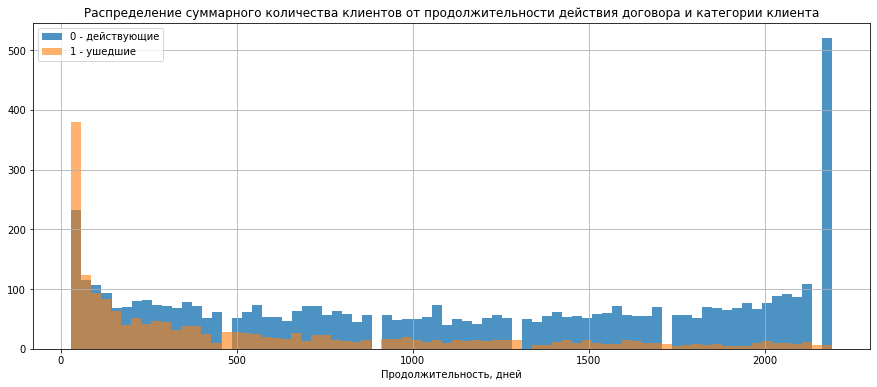

In [24]:
plt.figure(figsize = (15,6))
summary_activ['DayUsed'].hist(bins=76, alpha=.8)
summary_churn['DayUsed'].hist(bins=76, alpha=.6)
plt.grid
plt.title('Распределение суммарного количества клиентов от продолжительности действия договора и категории клиента')
plt.xlabel('Продолжительность, дней')
plt.legend(('0 - действующие', '1 - ушедшие'))
plt.show()

In [25]:
df_contract['BeginDateNew'].min()

Timestamp('2013-10-01 00:00:00')

In [26]:
print('for activ:\n', summary_activ['DayUsed'].describe())
print('\nfor churn:\n', summary_churn['DayUsed'].describe())

for activ:
 count   5,163.00
mean    1,146.89
std       732.77
min        31.00
25%       457.00
50%     1,157.00
75%     1,857.00
max     2,191.00
Name: DayUsed, dtype: float64

for churn:
 count   1,869.00
mean      547.35
std       594.39
min        30.00
25%        61.00
50%       304.00
75%       883.00
max     2,191.00
Name: DayUsed, dtype: float64


<div class="alert alert-info"> 
    Мы получили довольно интересное распределение для активных клиентов: график разрывается на блоки с равными промежутками между ними.
Возможно это подвыборки из данных, или искусственные данные, или еще что-то...
С клиентами, расторгнувшими договор, картина более менее приближенная к действительности, но есть один разрыв, который также совпадает с разрывом активных клиентов.

Если не учитывать 'разрывы' в распределении, то по общей картине можно сделать следующие выводы:
- Для действующих клиентов мы наблюдаем два пика. Левый соответствует периоду января 2020г. и составляет около 225-230 клиентов. Компания привлекла значительную часть клиентов за последний месяц работы, увеличив количество в 2 раза по сравнению с декабрем 2019 г. Второй пик (справа на гистограмме) показывает, что около 520 клиентов являются постоянными: они заключили договор с даты '2013-10-01' и до сих пор являются клиентами компании, что составляет около 7.5%.
- Медиана составляет 1157 дней - более трех лет 50% клиентов пользуются услугами компании. Среднее значение (1146) очень близко к медиане.


- Гистограмма оттока показывает, что клиенты покидают компанию в первые 4-5 месяцев, максимум ухода (пиковое значение в 370-380) приходится на следующий месяц после заключения договора, затем происходит снижение показателей до 80-90 и далее плавное снижение до 30-40 в течении плолутора лет. Отток клиентов, которые продолжительно пользуются услугами компании (более 3-х лет), небольшой - около 20 человек.
- Медиана составляет 304 дня, среднее - 547.

Посмотрим на распределение ежемесячных платежей `MonthlyCharges`.

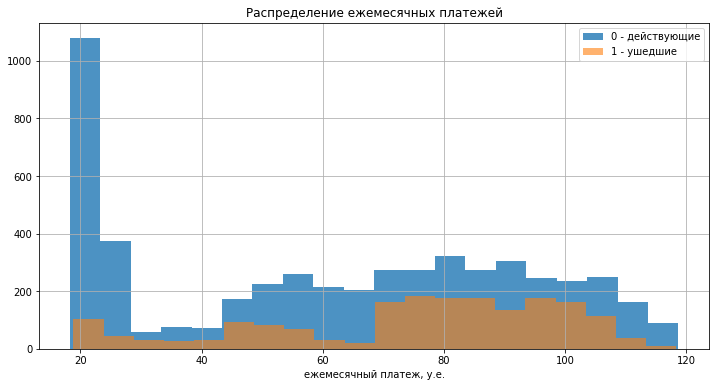

In [27]:
plt.figure(figsize = (12,6))
summary_activ['MonthlyCharges'].hist(bins=20, alpha=.8)
summary_churn['MonthlyCharges'].hist(bins=20, alpha=.6)
plt.grid
plt.title('Распределение ежемесячных платежей')
plt.xlabel('ежемесячный платеж, у.е.')
plt.legend(('0 - действующие', '1 - ушедшие'))
plt.show()

In [28]:
print('for activ:\n', summary_activ['MonthlyCharges'].describe())
print('\nfor churn:\n', summary_churn['MonthlyCharges'].describe())

for activ:
 count   5,163.00
mean       61.31
std        31.09
min        18.25
25%        25.10
50%        64.45
75%        88.47
max       118.75
Name: MonthlyCharges, dtype: float64

for churn:
 count   1,869.00
mean       74.44
std        24.67
min        18.85
25%        56.15
50%        79.65
75%        94.20
max       118.35
Name: MonthlyCharges, dtype: float64


- Распределение для действующих клиентов имеет несколько пиков: первый (слева) в значении 20 - самый максимальный (зачение больше 1000) и менее выраженные в значениях: 55, 80, 90. Вероятнее всего, выделение малых пиков связано с предлагаемыми тарифами на услуги или комплект услуг. Левый пик показывает самый популярный среднемесячный тариф для "эконом" класса: минимальная цена - максимальная популярность. Платеж в 80 у.е., возможно, указывает на популярный пакет в более "платежеспособном" сегменте клиентов. Медиана и среднее находятся в близких значениях (64.5/61.3).
- Максимальный отток клиентов происходит при среднемесячном платеже в 80, 100 у.е. а в сегменте 55 у.е. отток меньше примерно в 2 раза. Медиана и среднее находятся в значениях 79.7 и 74.4.
- Средний ежемесячный платеж действующих и ушедших клиентов различны. (Гипотеза, требующая проверки).

Изучим распределение суммарного платежа из столбца `TotalCharges` наших данных.

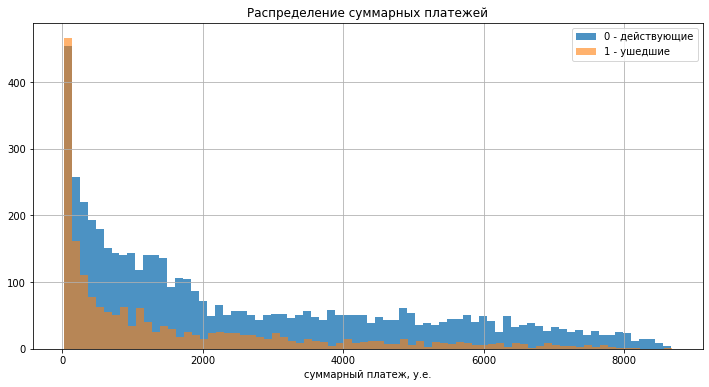

In [29]:
plt.figure(figsize = (12,6))
summary_activ['TotalCharges'].hist(bins=76, alpha=.8)
summary_churn['TotalCharges'].hist(bins=76, alpha=.6)
plt.grid
plt.title('Распределение суммарных платежей')
plt.xlabel('суммарный платеж, у.е.')
plt.legend(('0 - действующие', '1 - ушедшие'))
plt.show()

Максимальное кол-во оттока приходится на минимальные значения суммарных платежей, как было замечено ранее, пик максимального оттока приходится на второй месяц после заключения договора.
Оба распределения имеют тенденцию убывания к максимальным значениям суммарного платежа, что вполне логично и объяснимо: новых клиентов с небольшими суммарными платежами больше, чем постоянных клиентов с большими накопленными суммарными платежами.

К этой части анализа стоит обратиться после [главы 6.1.1. Отбор признаков по важности](#startpage_2).

<a id='startpage_3'></a>

#### Анализ  групп клиентов по типу договора

Изучим данные `Type` - тип договора подробнее. Создадим таблицу, в которой подсчитаем количество клиентов по каждому типу договора в зависимости от типа клиента.

In [30]:
type_count = df.groupby(['Churn', 'Type'])['Churn'].count().unstack('Churn')
type_count

Churn              0     1
Type                      
Month-to-month  2220  1655
One year        1306   166
Two year        1637    48

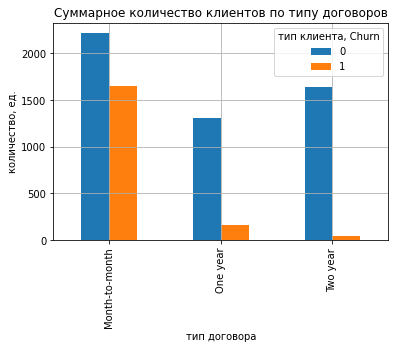

In [31]:
type_count.plot(kind='bar', grid=True, figsize=(6,4))
plt.legend(title='тип клиента, Churn')
plt.title('Суммарное количество клиентов по типу договоров')
plt.xlabel('тип договора')
plt.ylabel('количество, ед.')
plt.show()

Посмотрим на распределение в % в каждой представленной группе клиентов.

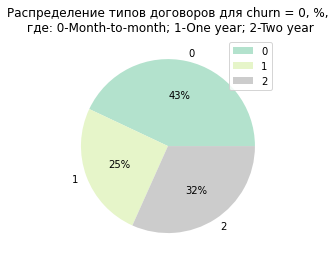

In [32]:
type_summary_activ = summary_activ.groupby(['Churn', 'Type'], as_index=False)['Churn'].count()
type_summary_activ['percent'] = type_summary_activ['Churn'] / sum(type_summary_activ['Churn']) * 100
type_summary_activ.plot(y='percent', kind='pie', label='',
                        cmap='Pastel2', autopct='%.0f%%')
plt.title('Распределение типов договоров для churn = 0, %,\n где: 0-Month-to-month; 1-One year; 2-Two year')
plt.show()

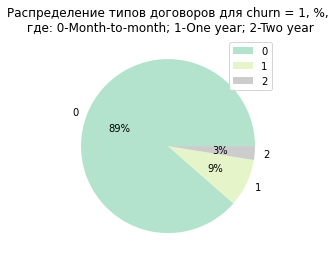

In [33]:
type_summary_churn = summary_churn.groupby(['Churn', 'Type'], as_index=False)['Churn'].count()
type_summary_churn['percent'] = type_summary_churn['Churn'] / sum(type_summary_churn['Churn']) * 100
type_summary_churn.plot(y='percent', kind='pie', label='',
                        cmap='Pastel2', autopct='%.0f%%')
plt.title('Распределение типов договоров для churn = 1, %,\n где: 0-Month-to-month; 1-One year; 2-Two year')
plt.show()

Клиенты `Churn`= 0 предпочитают разные виды договоров: 43% заключают ежемесячные договоры, 25% - годовые и 32% - двухгодичные.
Клиенты `Churn`= 1 почти не заключают двухгодичных договоров (на их долю приходится всего 3%); заключают 9% годичных договоров; превалирующая часть в 89% - это заключение договоров ежемесячно, то есть краткосрочные договоры, что предсказуемо из гистограммы 'Распределения суммарного количества клиентов от продолжительности действия договора'.

- Средние ежемесячные траты представлены в `type_monthly_charg`:

Посмотрим на данные ежемесячной и общей суммы трат в зависимости от типа договора и типу клиента по среднему значению.

In [34]:
type_monthly_charg_mean = df.groupby(['Churn', 'Type'])['MonthlyCharges'].mean().unstack('Churn')
type_monthly_charg_mean

Churn              0     1
Type                      
Month-to-month 61.46 73.02
One year       62.54 85.05
Two year       60.11 86.78

И медиане:

In [35]:
type_monthly_charg_median = df.groupby(['Churn', 'Type'])['MonthlyCharges'].median().unstack('Churn')
type_monthly_charg_median

Churn              0     1
Type                      
Month-to-month 64.95 79.05
One year       64.85 95.05
Two year       63.55 97.28

Значения по медиане выше по каждому типу договора в каждой группе клиентов. Среднее смещено в сторону более низких значений.

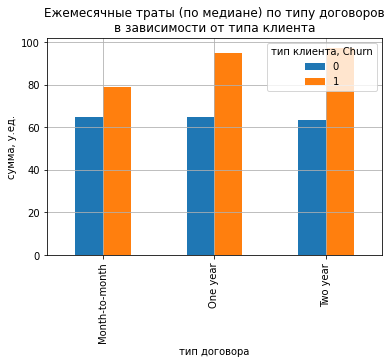

In [36]:
type_monthly_charg_median.plot(kind='bar', grid=True, figsize=(6,4))
plt.legend(title = 'тип клиента, Churn')
plt.title('Ежемесячные траты (по медиане) по типу договоров\nв зависимости от типа клиента')
plt.xlabel('тип договора')
plt.ylabel('сумма, у.ед.')
plt.show()

Ушедшие клиенты (`Churn`=1) тратили ежемесячно значительно большие суммы в отличие от клиентов действующих. Особенно это видно в договорах, заключенных на один и два года.

Возможно, действующие клиенты регулярно пользуются акциями и скидками, которые уменьшают их ежемесячные траты.

- Средняя сумма трат за весь период договора `type_total_charg`:

In [37]:
type_total_charg_mean = df.groupby(['Churn', 'Type'])['TotalCharges'].mean().unstack('Churn')
type_total_charg_mean

Churn                 0        1
Type                            
Month-to-month 1,521.93 1,164.46
One year       2,903.57 4,066.21
Two year       3,678.99 5,432.36

In [38]:
type_total_charg_median = df.groupby(['Churn', 'Type'])['TotalCharges'].median().unstack('Churn')
type_total_charg_median

Churn                 0        1
Type                            
Month-to-month   830.52   514.00
One year       2,477.30 4,098.52
Two year       3,527.00 5,874.25

Здесь значения по медиане ниже по ежемесячному договору в каждой группе клиентов. Среднее смещено в сторону более высоких значений, что указывает на ассиметрию-хвост правой части распределения.

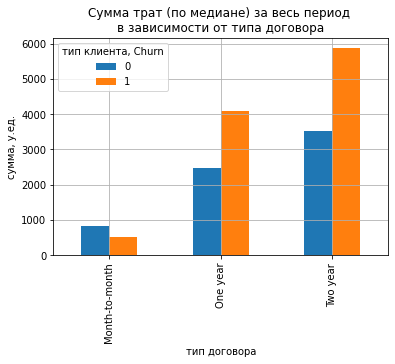

In [39]:
type_total_charg_median.plot(kind='bar', grid=True, figsize=(6,4))
plt.legend(title = 'тип клиента, Churn')
plt.title('Cумма трат (по медиане) за весь период \nв зависимости от типа договора')
plt.xlabel('тип договора')
plt.ylabel('сумма, у.ед.')
plt.show()

Общие суммы трат ушедших клиентов (`Churn`=1) значительно выше суммы трат клиентов действующих(`Churn`=0) в двухгодичном и годичном договорах. 
Траты же в ежемесячных платежах у ушедших клиентов чуть ниже.

Исходя из проведенного исследования, возможно, имеет смысл предлагать потенциально-планирующим уход клиентам двухгодичные и годичные договоры на специальных условиях для уменьшения их оттока.

### Гипотеза

- средний ежемесячный платеж действующих и ушедших клиентов различается.

Сформулируем нулевую гипотезу о том, что средний ежемесячный платеж действующих и ушедших клиентов равны, и альтернативную гипотезу, что средний ежемесячный платеж действующих и ушедших клиентов различаются. Пороговое значение alpha зададим в 0.05.

Чтобы проверить гипотезу о равенстве среднего наших генеральных совокупностей по взятым из них выборкам, применим метод scipy.stats.ttest_ind(), так как размеры выборок достаточно большие. В нашем случае размеры выборки (5163 для действующих и 1869 для ушедших клиентов) и дисперсии (стандартные отклонения: 31.09 и 24.67, соответственно) не равны в наших группах, поэтому передадим параметр: equal_var = False.

In [40]:
alpha = .05
results = st.ttest_ind(summary_activ['MonthlyCharges'], summary_churn['MonthlyCharges'], equal_var = False)
print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print ('Отвергаем нулевую гипотезу')
else:
    print ('Не получилось отвергнуть нулевую гипотезу')

p-значение:  2.657357144516026e-72
Отвергаем нулевую гипотезу


Данные предоставляют достаточное основание для выбранного уровня значимости отвергнуть нулевую гипотезу. Значит, можно сделать вывод, что средний ежемесячный платеж действующих и ушедших клиентов различаются. Даже при более строгом критическом значении статистической значимости в 0.01, мы бы получили тот же результат: p-value не превышает и этого значения.

## Подготовка данных для построения моделей

Для более корректной работы моделей необходимо убрать лишние признаки, коррелирующие между собой. 
Посмотрим на корреляции количественных признаков в наших данных. Обратимся к `Pearson’s correlation coefficient`.

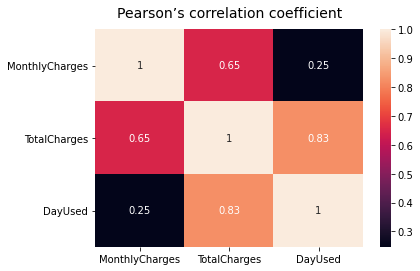

In [41]:
corr_matrix = df[['MonthlyCharges', 'TotalCharges', 'DayUsed']].corr()
heatmap_corr = sns.heatmap(corr_matrix, annot = True, fmt='.2g')
heatmap_corr.set_title('Pearson’s correlation coefficient', fontdict={'fontsize':14}, pad=12);

Коэффициент корреляции по шкале Чеддока между признаками `TotalCharges`-`DayUsed` высокий (0.83), а между `MonthlyCharges`-`TotalCharges` - заметный - 0.65. `TotalCharges`-`DayUsed` - коллинеарные признаки. 

Удалим столбец `TotalCharges`. Также удалим все столбцы, относящиеся ко временным признакам и столбец `СustomerID`.

In [42]:
df = df.drop(['TotalCharges', 'BeginDateNew', 'EndDateNew', 'СustomerID'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7031
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7032 non-null   object 
 1   PaperlessBilling  7032 non-null   object 
 2   PaymentMethod     7032 non-null   object 
 3   MonthlyCharges    7032 non-null   float64
 4   Churn             7032 non-null   int64  
 5   Gender            7032 non-null   object 
 6   SeniorCitizen     7032 non-null   int64  
 7   Partner           7032 non-null   object 
 8   Dependents        7032 non-null   object 
 9   InternetService   7032 non-null   object 
 10  OnlineSecurity    7032 non-null   object 
 11  OnlineBackup      7032 non-null   object 
 12  DeviceProtection  7032 non-null   object 
 13  TechSupport       7032 non-null   object 
 14  StreamingTV       7032 non-null   object 
 15  StreamingMovies   7032 non-null   object 
 16  MultipleLines     7032 non-null   object 


Теперь посмотрим на корреляции признаков, используя phik_matrix method, который в отличие от корреляции Пирсена может быть использован и для категориальных признаков, показывая не только линейные связи.

interval columns not set, guessing: ['MonthlyCharges', 'Churn', 'SeniorCitizen', 'DayUsed']


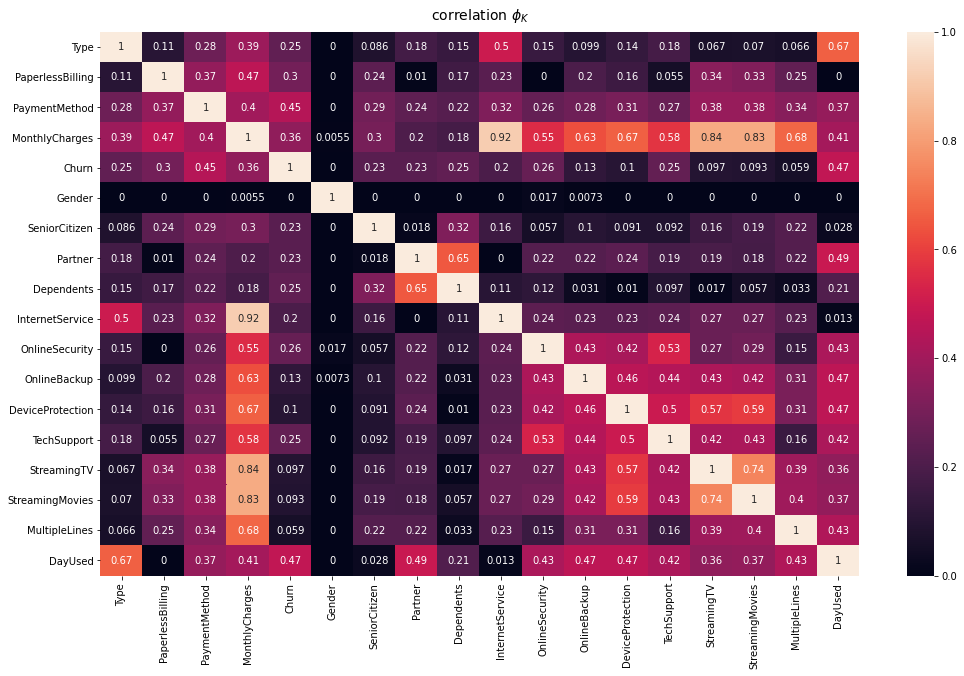

In [43]:
phik_overview = df.phik_matrix()
plt.figure(figsize = (17,10))
heatmap_ph = sns.heatmap(phik_overview, annot = True, fmt='.2g')
heatmap_ph.set_title(r'correlation $\phi_K$', fontdict={'fontsize':14}, pad=12);

Мы видим, высокие значения коэффициентов между признаками:
`MonthlyCharges` и `InternetService` (0.92);
`MonthlyCharges` и `StreamingTV` (0.84);
`MonthlyCharges` и `StreamingMovies` (0.83).

Посмотрим на статистическую значимость этих коэффициентов. Построим тепловую карту.

interval columns not set, guessing: ['MonthlyCharges']


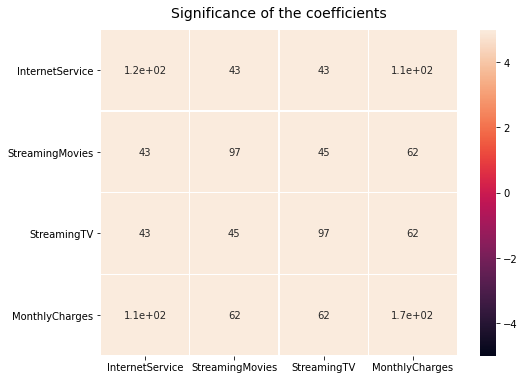

In [44]:
phic_matrix=df[['InternetService', 'StreamingMovies', 'StreamingTV', 'MonthlyCharges']]
significance_overview = phic_matrix.significance_matrix()
plt.figure(figsize = (8,6))
heatmap_s = sns.heatmap(significance_overview, annot = True, fmt='.2g', linewidths=.5, vmin=-5, vmax=5)
heatmap_s.set_title('Significance of the coefficients', fontdict={'fontsize':14}, pad=12);

Цветовая шкала матрицы указывает уровень значимости и насыщение при +/- 5 стандартных отклонениях. Все значения коэффициентов корреляции между указанными признаками статистически значимы.
Соответственно, признаки `MonthlyCharges`-`InternetService`, `MonthlyCharges`-`StreamingTV`, `MonthlyCharges`-`StreamingMovies` - коллинеарны.
Удалим столбцы `InternetService`, `StreamingTV`, `StreamingMovies`.

In [45]:
df = df.drop(['InternetService', 'StreamingTV', 'StreamingMovies'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7031
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7032 non-null   object 
 1   PaperlessBilling  7032 non-null   object 
 2   PaymentMethod     7032 non-null   object 
 3   MonthlyCharges    7032 non-null   float64
 4   Churn             7032 non-null   int64  
 5   Gender            7032 non-null   object 
 6   SeniorCitizen     7032 non-null   int64  
 7   Partner           7032 non-null   object 
 8   Dependents        7032 non-null   object 
 9   OnlineSecurity    7032 non-null   object 
 10  OnlineBackup      7032 non-null   object 
 11  DeviceProtection  7032 non-null   object 
 12  TechSupport       7032 non-null   object 
 13  MultipleLines     7032 non-null   object 
 14  DayUsed           7032 non-null   int64  
dtypes: float64(1), int64(3), object(11)
memory usage: 879.0+ KB


### Обучающая и тестовая выборки

Данные целевого признака `Churn` категориальные. Будем решать задачу бинарной классификации ('Churn' = 1 - клиент ушел).

Разделим наши данные в соотношении 70/30 - обучающая/тестовая выборки.

In [48]:
features_train = df.drop(['Churn'],axis = 1)
target_train = df['Churn']

features_train, features_test, target_train, target_test = train_test_split(features_train, target_train, 
                                                                            test_size=0.30, 
                                                                            random_state=r_s,
                                                                            stratify=target_train)
display(features_train.shape)
display(target_train.shape)
display(features_test.shape)
display(target_test.shape)

(4922, 14)

(4922,)

(2110, 14)

(2110,)

Посмотрим на баланс классов в обучающей и тестовой выборках.

In [49]:
display(target_train.value_counts(normalize=True))
target_test.value_counts(normalize=True)

0   0.73
1   0.27
Name: Churn, dtype: float64

0   0.73
1   0.27
Name: Churn, dtype: float64

Данные разделены равномерно между тестовой и обучающей выборкой.

Создадим копии обучающей и тестовой выборки для работы с моделью `CatBoostClassifier` без дальнейшего преобразования категориальных признаков, поскольку `CatBoost` имеет свой внутренний способ кодирования данных признаков.

In [50]:
features_train_boost = features_train.copy()
target_train_boost = target_train.copy()
features_test_boost = features_test.copy()
target_test_boost = target_test.copy()

#### Преобразование категориальных признаков

Все столбцы, состоящие из категориальных признаков, относятся к номинальной категории. 

`Type`, `PaperlessBilling`, `PaymentMethod`, `Gender`, `Partner`, `Dependents`, `OnlineSecurity`, `OnlineBackup`, `DeviceProtection`, `TechSupport`, `MultipleLines`  преобразуем техникой `OHE`, реализовав функцией pd.get_dummies.

In [51]:
features_train = pd.get_dummies(features_train, drop_first=True)
features_test = pd.get_dummies(features_test, drop_first=True)

In [52]:
features_train.sample(2).T

1282  5837
MonthlyCharges                        74.10 76.10
SeniorCitizen                          0.00  0.00
DayUsed                               31.00 92.00
Type_One year                          1.00  0.00
Type_Two year                          0.00  0.00
PaperlessBilling_Yes                   0.00  0.00
PaymentMethod_Credit card (automatic)  1.00  0.00
PaymentMethod_Electronic check         0.00  1.00
PaymentMethod_Mailed check             0.00  0.00
Gender_Male                            0.00  0.00
Partner_Yes                            0.00  0.00
Dependents_Yes                         0.00  0.00
OnlineSecurity_Yes                     0.00  0.00
OnlineBackup_Yes                       0.00  0.00
DeviceProtection_Yes                   1.00  0.00
TechSupport_Yes                        1.00  0.00
MultipleLines_Yes                      0.00  1.00

#### Масштабирование количественных признаков

Сделаем масштабирование количественных признаков методом стандартизации данных.

In [53]:
numeric = ['MonthlyCharges', 'DayUsed']

scaler = StandardScaler()

scaler.fit(features_train[numeric])

features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

In [54]:
features_test[numeric].sample(3)

MonthlyCharges  DayUsed
6124           -1.33    -1.24
4521           -0.52    -0.95
2264            0.20    -1.28

## Обучение моделей

Нашими исследуемыми моделями будут:
* RandomForestClassifier
* LogisticRegression
* SVM
* CatBoostClassifier

Для подбора оптимальных параметров наших моделей используем функцию `Gridsearchcv`.

В качестве метрики будем использовать `ROC_AUC` и `F1`.

### RandomForestClassifier

In [77]:
%%time
# Создадим параметры для модели RandomForest
param_grid_rf = {
    'max_depth': range(14, 20, 2),
    'min_samples_leaf': [1, 2],
    'n_estimators': range(80, 120, 10),
    'class_weight': ['balanced', None]
}

rf = RandomForestClassifier(random_state=r_s)

grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, scoring='roc_auc', 
                              verbose=2, cv=5, n_jobs=-1)

grid_search_rf.fit(features_train, target_train)

print("ROC_AUC лучшей модели RandomForest:", grid_search_rf.best_score_.round(4),
      "\nЛучшая модель:", grid_search_rf.best_params_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END class_weight=balanced, max_depth=14, min_samples_leaf=1, n_estimators=80; total time=   0.4s
[CV] END class_weight=balanced, max_depth=14, min_samples_leaf=1, n_estimators=80; total time=   0.4s
[CV] END class_weight=balanced, max_depth=14, min_samples_leaf=1, n_estimators=80; total time=   0.3s
[CV] END class_weight=balanced, max_depth=14, min_samples_leaf=1, n_estimators=80; total time=   0.3s
[CV] END class_weight=balanced, max_depth=14, min_samples_leaf=1, n_estimators=80; total time=   0.3s
[CV] END class_weight=balanced, max_depth=14, min_samples_leaf=1, n_estimators=90; total time=   0.4s
[CV] END class_weight=balanced, max_depth=14, min_samples_leaf=1, n_estimators=90; total time=   0.4s
[CV] END class_weight=balanced, max_depth=14, min_samples_leaf=1, n_estimators=90; total time=   0.4s
[CV] END class_weight=balanced, max_depth=14, min_samples_leaf=1, n_estimators=90; total time=   0.4s
[CV] END class_weigh

- с балансом классов (class_weight='balanced'):

ROC_AUC лучшей модели RandomForest: 0.8493 

Лучшая модель: {'max_depth': 18, 'min_samples_leaf': 2, 'n_estimators': 110}

CPU times: user 45.6 s, sys: 255 ms, total: 45.8 s
Wall time: 45.9 s

________
- 'class_weight': None

ROC_AUC лучшей модели RandomForest: 0.8507

Лучшая модель: {'class_weight': None, 'max_depth': 14, 'min_samples_leaf': 2, 'n_estimators': 110}

CPU times: user 1min 34s, sys: 650 ms, total: 1min 35s
Wall time: 1min 37s

#### Отбор признаков по важности (с использованием RandomForestClassifier)
<a id='startpage_2'></a> 

Посмотрим на наши данные с точки зрения важности каждого признака.

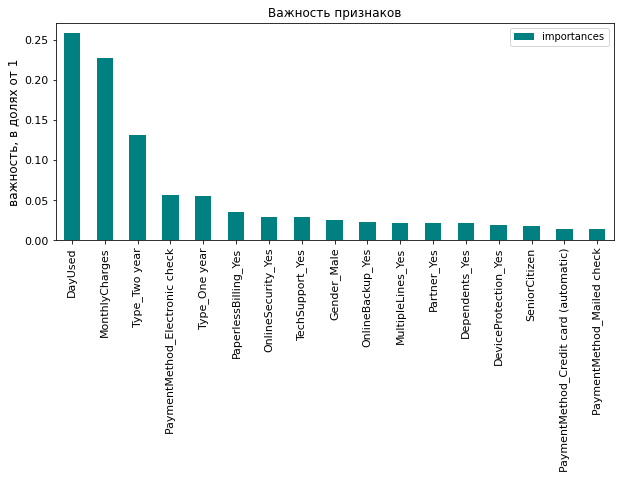

In [56]:
features_importance = pd.DataFrame(grid_search_rf.best_estimator_.feature_importances_, 
                              index = features_test.columns, columns=['importances'])
features_importance = features_importance.sort_values(by='importances', ascending=False)
features_importance.plot(kind='bar', figsize=(10, 4), title='Важность признаков', fontsize=11, color='teal')
plt.ylabel('важность, в долях от 1', fontsize=12)
plt.show()

Гистограмма показывает важность каждого признака. Наиболее значимыми являются `DayUsed`, `MonthlyCharges` и `Type_Two year`. Очевидно, что созданный нами признак `DayUsed` оказался самым важным. Интересно, что заключение 2-х годичного договора (`Type_Two year`) также значимо в качестве признака для нашего исследования.
Посмотрим на численные характеристики признаков в таблице `features_importance`.

In [57]:
features_importance

importances
DayUsed                                       0.26
MonthlyCharges                                0.23
Type_Two year                                 0.13
PaymentMethod_Electronic check                0.06
Type_One year                                 0.06
PaperlessBilling_Yes                          0.04
OnlineSecurity_Yes                            0.03
TechSupport_Yes                               0.03
Gender_Male                                   0.02
OnlineBackup_Yes                              0.02
MultipleLines_Yes                             0.02
Partner_Yes                                   0.02
Dependents_Yes                                0.02
DeviceProtection_Yes                          0.02
SeniorCitizen                                 0.02
PaymentMethod_Credit card (automatic)         0.01
PaymentMethod_Mailed check                    0.01

`DayUsed`(27%), `MonthlyCharges`(24%) и `Type_Two year`(12%) в сумме составляют более половины - 63%.
Наименее важный признак - `PaymentMethod_Mailed check`, значимость которого 1%.
Передадим все представленные в таблице признаки моделям машинного обучения.

Вернуться и продолжить тему [Исследование задачи](#startpage_3).

### LogisticRegression

In [58]:
%%time
param_grid_lg = {
    'solver': ['lbfgs', 'liblinear'],
    'max_iter': [100, 1000, 100],
    'C': [0.01, 0.1, 1, 10, 100, 1000],
    'class_weight': ['balanced', None]
}

lg = LogisticRegression(random_state=r_s)

grid_search_lg = GridSearchCV(estimator=lg, param_grid=param_grid_lg, scoring='roc_auc', 
                           cv=5, n_jobs=-1)

grid_search_lg.fit(features_train, target_train)

print("ROC_AUC лучшей модели LogisticRegression:", grid_search_lg.best_score_.round(4),
      "\nЛучшая модель:", grid_search_lg.best_params_)

ROC_AUC лучшей модели LogisticRegression: 0.8373 
Лучшая модель: {'C': 1, 'class_weight': None, 'max_iter': 100, 'solver': 'liblinear'}
CPU times: user 55.4 s, sys: 1min 44s, total: 2min 40s
Wall time: 2min 40s


ROC_AUC лучшей модели LogisticRegression: 0.8373

Лучшая модель: {'C': 1, 'class_weight': None, 'max_iter': 100, 'solver': 'liblinear'}

CPU times: user 55.4 s, sys: 1min 44s, total: 2min 40s
Wall time: 2min 40s
__________
with class_weight='balanced'

ROC_AUC лучшей модели LogisticRegression: 0.8382

Лучшая модель: {'C': 0.1, 'max_iter': 100, 'solver': 'liblinear'}

CPU times: user 20.3 s, sys: 23.5 s, total: 43.9 s
Wall time: 43.9 s

### SVM

In [59]:
%%time
param_grid_svm={
    'C': [1, 10], 
    'kernel': ('linear', 'sigmoid')
}

svc = svm.SVC(random_state=r_s, class_weight='balanced')

grid_search_svc = GridSearchCV(estimator=svc, param_grid=param_grid_svm, scoring='roc_auc', 
                              cv=5, n_jobs=-1)

grid_search_svc.fit(features_train, target_train)

print("ROC_AUC лучшей модели SVM:", grid_search_svc.best_score_.round(4),
      "\nЛучшая модель:", grid_search_svc.best_params_)

ROC_AUC лучшей модели SVM: 0.8355 
Лучшая модель: {'C': 1, 'kernel': 'linear'}
CPU times: user 13.3 s, sys: 0 ns, total: 13.3 s
Wall time: 13.4 s


ROC_AUC лучшей модели SVM: 0.8365

Лучшая модель: {'C': 1, 'kernel': 'linear'}

CPU times: user 12.8 s, sys: 124 ms, total: 12.9 s
Wall time: 13.2 s

### CatBoostClassifier

#### CatBoostClassifier без преобразования признаков

In [60]:
%%time
param_grid_cb = {
    'learning_rate': [0.1, 0.3, 0.5],
    'depth': [4, 6, 10],
    'l2_leaf_reg': [1, 3, 5]
}

cb = CatBoostClassifier(random_state=r_s, verbose=2, 
                        iterations=300, cat_features=['Type', 'PaperlessBilling', 'PaymentMethod',
                                                      'Gender', 'Partner', 'Dependents', 'OnlineSecurity',
                                                      'OnlineBackup', 'DeviceProtection', 'TechSupport', 'MultipleLines'])
grid_search_cb = GridSearchCV(cb, param_grid=param_grid_cb, cv=5, scoring='roc_auc')
grid_search_cb.fit(features_train_boost, target_train_boost)

print("\nЛучшая модель:", grid_search_cb.best_params_)
print("ROC_AUC лучшей модели CatBoostClassifier:", grid_search_cb.best_score_.round(4))

0:	learn: 0.6454679	total: 55.9ms	remaining: 16.7s
2:	learn: 0.5783049	total: 63ms	remaining: 6.24s
4:	learn: 0.5215910	total: 70ms	remaining: 4.13s
6:	learn: 0.4809873	total: 76.5ms	remaining: 3.2s
8:	learn: 0.4587073	total: 81.8ms	remaining: 2.64s
10:	learn: 0.4426936	total: 88.3ms	remaining: 2.32s
12:	learn: 0.4327761	total: 94ms	remaining: 2.08s
14:	learn: 0.4243209	total: 100ms	remaining: 1.9s
16:	learn: 0.4179220	total: 106ms	remaining: 1.77s
18:	learn: 0.4142469	total: 112ms	remaining: 1.66s
20:	learn: 0.4103552	total: 117ms	remaining: 1.56s
22:	learn: 0.4072740	total: 123ms	remaining: 1.49s
24:	learn: 0.4048197	total: 130ms	remaining: 1.43s
26:	learn: 0.4027322	total: 136ms	remaining: 1.37s
28:	learn: 0.3998041	total: 145ms	remaining: 1.35s
30:	learn: 0.3983537	total: 151ms	remaining: 1.31s
32:	learn: 0.3969766	total: 157ms	remaining: 1.27s
34:	learn: 0.3933835	total: 163ms	remaining: 1.23s
36:	learn: 0.3923064	total: 169ms	remaining: 1.2s
38:	learn: 0.3909924	total: 175ms	rema

Лучшая модель: {'depth': 4, 'l2_leaf_reg': 1, 'learning_rate': 0.3}

ROC_AUC лучшей модели CatBoostClassifier: 0.9228

CPU times: user 6min 37s, sys: 11.6 s, total: 6min 49s
Wall time: 8min 14s

In [76]:
%%time
param_grid_cb = {
    'learning_rate': [0.1, 0.3, 0.5],
    'depth': [4, 6, 10],
    'l2_leaf_reg': [1, 3, 5]
}

cb = CatBoostClassifier(random_state=r_s, verbose=2, 
                        iterations=300, cat_features=['Type', 'PaperlessBilling', 'PaymentMethod',
                                                      'Gender', 'Partner', 'Dependents', 'OnlineSecurity',
                                                      'OnlineBackup', 'DeviceProtection', 'TechSupport', 'MultipleLines'])
half_grid_search_cb = HalvingGridSearchCV(cb, param_grid=param_grid_cb, cv=5, scoring='roc_auc')
half_grid_search_cb.fit(features_train_boost, target_train_boost)

print("\nЛучшая модель:", half_grid_search_cb.best_params_)
print("ROC_AUC лучшей модели CatBoostClassifier:", half_grid_search_cb.best_score_.round(4))

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 182
max_resources_: 4922
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 27
n_resources: 182
Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV 1/5; 1/27] START depth=4, l2_leaf_reg=1, learning_rate=0.1..................
0:	learn: 0.6256897	total: 1.68ms	remaining: 503ms
2:	learn: 0.5152890	total: 3.27ms	remaining: 324ms
4:	learn: 0.4736126	total: 4.51ms	remaining: 266ms
6:	learn: 0.4297381	total: 5.79ms	remaining: 242ms
8:	learn: 0.3842171	total: 8.21ms	remaining: 265ms
10:	learn: 0.3564564	total: 10.5ms	remaining: 277ms
12:	learn: 0.3387394	total: 12.7ms	remaining: 279ms
14:	learn: 0.3285739	total: 14.9ms	remaining: 284ms
16:	learn: 0.3181927	total: 17ms	remaining: 282ms
18:	learn: 0.3150294	total: 18.2ms	remaining: 269ms
20:	learn: 0.3146156	total: 19ms	remaining: 253ms
22:	learn: 0.3061594	total: 20.3ms	remaining: 245ms
24:	learn: 0.2981439	total: 21.8ms	remaini

- HalvingGridSearchCV 

Лучшая модель: {'depth': 4, 'l2_leaf_reg': 3, 'learning_rate': 0.1}

ROC_AUC лучшей модели CatBoostClassifier: 0.9005

CPU times: user 6min 29s, sys: 10.9 s, total: 6min 40s
Wall time: 8min 55s

#### CatBoostClassifier с преобразованием признаков

In [61]:
%%time

cb_transform = CatBoostClassifier(random_state=r_s, verbose=2, iterations=300)

grid_search_cb_transform = GridSearchCV(cb_transform, param_grid=param_grid_cb, cv=5, scoring='roc_auc')
grid_search_cb_transform.fit(features_train, target_train)

print("\nЛучшая модель:", grid_search_cb_transform.best_params_)
print("ROC_AUC лучшей модели CatBoostClassifier_transform:", grid_search_cb_transform.best_score_.round(4))

0:	learn: 0.6425065	total: 1.2ms	remaining: 360ms
2:	learn: 0.5606131	total: 3.18ms	remaining: 315ms
4:	learn: 0.5132713	total: 5.38ms	remaining: 317ms
6:	learn: 0.4796864	total: 7.48ms	remaining: 313ms
8:	learn: 0.4612599	total: 9.54ms	remaining: 308ms
10:	learn: 0.4431888	total: 11.6ms	remaining: 304ms
12:	learn: 0.4332952	total: 13.6ms	remaining: 300ms
14:	learn: 0.4241569	total: 15.5ms	remaining: 295ms
16:	learn: 0.4183207	total: 17.5ms	remaining: 292ms
18:	learn: 0.4122974	total: 19.5ms	remaining: 288ms
20:	learn: 0.4066198	total: 21.5ms	remaining: 286ms
22:	learn: 0.4035797	total: 23.5ms	remaining: 283ms
24:	learn: 0.3980137	total: 25.6ms	remaining: 281ms
26:	learn: 0.3952860	total: 27.5ms	remaining: 278ms
28:	learn: 0.3901199	total: 29.6ms	remaining: 277ms
30:	learn: 0.3881120	total: 31.6ms	remaining: 274ms
32:	learn: 0.3855019	total: 33.7ms	remaining: 272ms
34:	learn: 0.3843492	total: 35.6ms	remaining: 269ms
36:	learn: 0.3828829	total: 37.5ms	remaining: 267ms
38:	learn: 0.37985

Лучшая модель: {'depth': 4, 'l2_leaf_reg': 3, 'learning_rate': 0.3}

**ROC_AUC лучшей модели CatBoostClassifier_transform: 0.9233**

CPU times: user 4min 16s, sys: 6 s, total: 4min 22s
Wall time: 5min 55s

## Анализ лучшей модели

### Тестирование модели

Лучше всего на обучающей выборке показала себя модель `CatBoostClassifier`. Были обучены модели без предварительного преобразования признаков и с применением техникой `OHE` и `StandardScaler`. Чуть лучше метрику ROC_AUC показала модель с предобработанными признаками: 0.9233 и 0.9228 - без их преобразования.

Проверим обе модели с подобранными нами гиперпараметрами на тестовой выборке.
Посмотрим метрики F1 и ROC-AUC.

In [62]:
%%time
# Параметры лучшей модели без преобразования признаков: {'depth': 4, 'l2_leaf_reg': 1, 'learning_rate': 0.3}

cb_best = CatBoostClassifier(random_state=r_s, depth=4, learning_rate=0.3, l2_leaf_reg=1, verbose=10, 
                             iterations=300, cat_features=['Type', 'PaperlessBilling', 'PaymentMethod',
                                                           'Gender', 'Partner', 'Dependents', 'OnlineSecurity',
                                                           'OnlineBackup', 'DeviceProtection', 'TechSupport', 'MultipleLines'])
cb_best.fit(features_train_boost, target_train_boost)
predicted_test = cb_best.predict(features_test_boost)
f1 = f1_score(target_test_boost, predicted_test)
print("F1 лучшей модели CatBoostClassifier на тестовых данных:", f1.round(4))

0:	learn: 0.5639427	total: 4.8ms	remaining: 1.44s
10:	learn: 0.3797718	total: 55.4ms	remaining: 1.45s
20:	learn: 0.3523404	total: 97.9ms	remaining: 1.3s
30:	learn: 0.3433370	total: 149ms	remaining: 1.29s
40:	learn: 0.3233714	total: 190ms	remaining: 1.2s
50:	learn: 0.3063925	total: 235ms	remaining: 1.15s
60:	learn: 0.2941574	total: 280ms	remaining: 1.09s
70:	learn: 0.2817743	total: 323ms	remaining: 1.04s
80:	learn: 0.2759255	total: 365ms	remaining: 988ms
90:	learn: 0.2645791	total: 411ms	remaining: 943ms
100:	learn: 0.2571146	total: 449ms	remaining: 885ms
110:	learn: 0.2487309	total: 492ms	remaining: 838ms
120:	learn: 0.2393713	total: 543ms	remaining: 803ms
130:	learn: 0.2285882	total: 587ms	remaining: 757ms
140:	learn: 0.2227937	total: 630ms	remaining: 711ms
150:	learn: 0.2154665	total: 677ms	remaining: 668ms
160:	learn: 0.2106714	total: 717ms	remaining: 619ms
170:	learn: 0.2048492	total: 761ms	remaining: 574ms
180:	learn: 0.1990417	total: 799ms	remaining: 525ms
190:	learn: 0.1957543	t

F1 лучшей модели CatBoostClassifier на тестовых данных: 0.7769

CPU times: user 1.23 s, sys: 13.2 ms, total: 1.25 s
Wall time: 1.77 s

In [63]:
%%time
# Параметры лучшей модели CatBoostClassifier с преобразованием признаков: 
# {'depth': 4, 'l2_leaf_reg': 3, 'learning_rate': 0.3}

cb_best_tr = CatBoostClassifier(random_state=r_s, depth=4, learning_rate=0.3, l2_leaf_reg=3, iterations=300, verbose=10)
cb_best_tr.fit(features_train, target_train)
predicted_test_tr = cb_best_tr.predict(features_test)
f1_tr = f1_score(target_test, predicted_test_tr)
print("F1 лучшей модели CatBoostClassifier_transform на тестовых данных:", f1_tr.round(4))

0:	learn: 0.5436072	total: 1.23ms	remaining: 368ms
10:	learn: 0.3910379	total: 13.5ms	remaining: 354ms
20:	learn: 0.3667121	total: 25.2ms	remaining: 335ms
30:	learn: 0.3487242	total: 39.9ms	remaining: 346ms
40:	learn: 0.3249012	total: 52ms	remaining: 328ms
50:	learn: 0.3092142	total: 64.2ms	remaining: 314ms
60:	learn: 0.2990568	total: 76.1ms	remaining: 298ms
70:	learn: 0.2871024	total: 88ms	remaining: 284ms
80:	learn: 0.2718506	total: 103ms	remaining: 279ms
90:	learn: 0.2626349	total: 122ms	remaining: 281ms
100:	learn: 0.2526431	total: 141ms	remaining: 278ms
110:	learn: 0.2448146	total: 154ms	remaining: 262ms
120:	learn: 0.2366398	total: 165ms	remaining: 245ms
130:	learn: 0.2303256	total: 181ms	remaining: 234ms
140:	learn: 0.2235334	total: 194ms	remaining: 219ms
150:	learn: 0.2188003	total: 206ms	remaining: 204ms
160:	learn: 0.2133727	total: 218ms	remaining: 188ms
170:	learn: 0.2090588	total: 230ms	remaining: 173ms
180:	learn: 0.2034796	total: 242ms	remaining: 159ms
190:	learn: 0.19881

F1 лучшей модели CatBoostClassifier_transform на тестовых данных: 0.765

CPU times: user 480 ms, sys: 29.4 ms, total: 509 ms
Wall time: 2.57 s

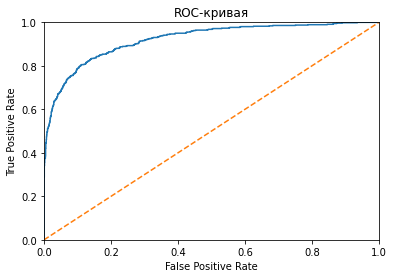

Метрики CatBoostClassifier с преобразованием признаков:

F1: 0.7495 
ROC_AUC: 0.9214


In [64]:
# ROC_AUC CatBoostClassifier_transform на обучающей выборке: 0.9233

probabilities_test = cb_best_tr.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)

roc_auc_tr = roc_auc_score(target_test, probabilities_one_test)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

print('Метрики CatBoostClassifier с преобразованием признаков:\n')
print("F1:", f1_tr.round(4), "\nROC_AUC:", roc_auc_tr.round(4))

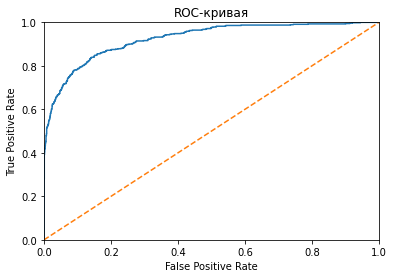

Метрики CatBoostClassifier без преобразования признаков:

F1: 0.7542 
ROC_AUC: 0.9248


In [65]:
# ROC_AUC CatBoostClassifier на обучающей выборке:  0.9228

probabilities_test = cb_best.predict_proba(features_test_boost)
probabilities_one_test = probabilities_test[:, 1]

fpr, tpr, thresholds = roc_curve(target_test_boost, probabilities_one_test)

roc_auc = roc_auc_score(target_test_boost, probabilities_one_test)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

print('Метрики CatBoostClassifier без преобразования признаков:\n')
print("F1:", f1.round(4), "\nROC_AUC:", roc_auc.round(4))

Проверка качества работы моделей `CatBoostClassifier` (с предобработкой признаков и без нее ) на тестовых данных показала примерно одинаковые результаты.

### Confusion Matrix

Для визуализации качества предсказания моделей обратимся к `Confusion Matrix`. Используем функцию.

In [66]:
def model_conf_matrix(model, feature, target):

    pred = model.predict(feature)
    conf_matrix = confusion_matrix(target, pred)
    
    print('F1_score = {:.3}'.format(f1_score(target, pred)))
    
    plt.figure(figsize=(4,4))
    sns.heatmap(conf_matrix, annot=True, cmap="Oranges", cbar=False, fmt="d")
    plt.title('Confusion Matrix');

1. CatBoostClassifier_transform, тестовая выборка
F1_score = 0.75


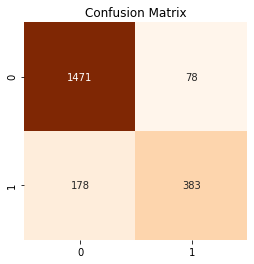

In [67]:
print('1. CatBoostClassifier_transform, тестовая выборка')
model_conf_matrix(cb_best_tr, features_test, target_test)

In [68]:
print(classification_report(target_test, predicted_test_tr))

              precision    recall  f1-score   support

           0       0.89      0.95      0.92      1549
           1       0.83      0.68      0.75       561

    accuracy                           0.88      2110
   macro avg       0.86      0.82      0.83      2110
weighted avg       0.88      0.88      0.87      2110



2. CatBoostClassifier, тестовая выборка
F1_score = 0.754


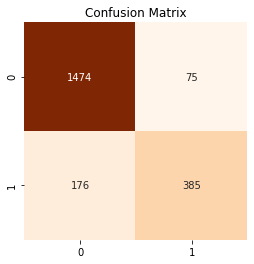

In [69]:
print('2. CatBoostClassifier, тестовая выборка')
model_conf_matrix(cb_best, features_test_boost, target_test_boost)

In [70]:
print(classification_report(target_test_boost, predicted_test))

              precision    recall  f1-score   support

           0       0.89      0.95      0.92      1549
           1       0.84      0.69      0.75       561

    accuracy                           0.88      2110
   macro avg       0.87      0.82      0.84      2110
weighted avg       0.88      0.88      0.88      2110



Поскольку в нашем исследовании стоит задача выявления клиентов, собирающихся покинуть компанию, то нас в большей степени интересует ошибка 2-го рода: когда клиент собирается уходить, а модель предсказывает, что он останется клиентом компании, чем ошибка 1-го рода, когда клиент не планирует уход, а модель определяет его, как собирающегося уйти.

Ошибка 2-го рода в модели `CatBoostClassifier_transform` выше, чем в модели `CatBoostClassifier`: 169/160.
Ошибка 1-го рода также выше в 1-й модели: 78/76.

Суммарно ошибки составляют 11.7% для `CatBoostClassifier_transform` и 11.2% - для `CatBoostClassifier` от предсказанных значений на тестовой выборке.

То есть модель `CatBoostClassifier` (без трансформации признаков) более точно определяет "отточных" клиентов.

### Вывод

**Для дальнейшего прогнозирования оттока клиентов у оператора связи «Ниединогоразрыва.ком» мы обучили модель "CatBoostClassifier" без использования техник `OHE` и `StandardScaler`, применив следующие гиперпараметры:**
- random_state=250722
- depth=4
- learning_rate=0.3
- l2_leaf_reg=1

**Метрики данной модели:**
- F1: 0.7769 
- ROC_AUC: 0.9338

**Рекомендации:** для уменьшения оттока клиентов предлагать потенциально-планирующим уход клиентам двухгодичные и годичные договоры на специальных условиях.

Вернуться в [начало](#startpage).